In [1]:
!pip install qiskit[visualization]
!pip install pyscf

     |████████████████████████████████| 6.0MB 28.3MB/s 
     |████████████████████████████████| 18.0MB 222kB/s 
     |████████████████████████████████| 235kB 46.6MB/s 
     |████████████████████████████████| 215kB 43.9MB/s 
     |████████████████████████████████| 2.1MB 40.7MB/s 
     |████████████████████████████████| 163kB 49.7MB/s 
     |████████████████████████████████| 1.5MB 37.4MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 194kB 38.9MB/s 
     |████████████████████████████████| 112kB 39.2MB/s 
     |████████████████████████████████| 614kB 32.5MB/s 
     |████████████████████████████████| 3.2MB 36.3MB/s 
     |████████████████████████████████| 6.3MB 30.0MB/s 
  Created wheel for qiskit: filename=qiskit-0.26.2-cp37-none-any.whl size=10506 sha256=aadc4a23b64fe508f59360dcfed295deb7bc8d9d191530c858285414b5688245
  Stored in directory: /root/.cache/pip/wheels/89/89/34/524839952d5a58a7be9789e580bfc1ca883bf6579152444568
  Created wheel

In [2]:
import qiskit
import numpy as np

from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.algorithms.optimizers import COBYLA
from qiskit.providers.ibmq import least_busy
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua import QuantumInstance
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


In [3]:
IBMQ.enable_account("8ee0cdbd442f6bb654b16a42a75546db448bed4a29f8874f7a3c96e4ba6381db750772327bbc111999756c30f142b957e3f6de4fb20c7622cf177b54c1df38c8")

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.get_provider(hub='ibm-q-minho')

## Molecule Definitions

In [5]:
r = 0.37 # radius in angstrom
h2 = 'H 0.0 0.0 0.0; H 0.0 0.0 {}'
charge = 0
spin = 0
driver = PySCFDriver(h2.format(2*r), 
                     charge = charge,
                     spin = spin,
                     basis='sto3g')
h2 = driver.run()

r = 0.5 # radius in angstrom
helonium = 'He 0.0 0.0 0.0; H 0.0 0.0 {}'
charge = +1
spin = 0
driver = PySCFDriver(helonium.format(2*r), 
                     charge = charge,
                     spin = spin,
                     basis='sto3g')
helonium = driver.run()

## Choosing the Molecule

In [6]:
molecule = h2

In [7]:
if molecule == h2:
  name = "H2"
if molecule == helonium:
  name = "HeH+"
  
# Define the fermion to qubit mapping and forbit qubit reduction
observable =  Hamiltonian(qubit_mapping=QubitMappingType.JORDAN_WIGNER,
                          two_qubit_reduction=False)

# Get the qubit operator representing the hamiltonian, as well as the 
#auxiliary operators for the total particle number, S^2 spin, etc.
# These allow checking their expectation values in the state
qubitOp, auxOps = observable.run(molecule)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:88: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  pauli_list = WeightedPauliOperator(paulis=

## UCCSD VQE

### Ansatz

In [8]:
# Set the Hartree Fock state as reference
initial_state = HartreeFock(
    observable.molecule_info['num_orbitals'],
    observable.molecule_info['num_particles'],
    qubit_mapping='jordan_wigner',
    two_qubit_reduction = False
) 

# Create the UCCSD ansatz with HF as initial state
uccsd = UCCSD(observable.molecule_info['num_orbitals'], 
              observable.molecule_info['num_particles'], 
              reps=1,
              num_time_slices=1,
              qubit_mapping='jordan_wigner',
              two_qubit_reduction=False,
              initial_state = initial_state)

# Create parameter vector
paramsNumber = uccsd.num_parameters
parameters = ParameterVector("Params",paramsNumber)

/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/initial_states/hartree_fock.py:61: DeprecationWarning: The HartreeFock class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the release date. Instead, all algorithms and circuits accept a plain QuantumCircuit. 
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/components/variational_forms/variational_form.py:48: DeprecationWarning: The package qiskit.aqua.components.variational_forms is deprecated. For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.components.variational_forms')


### Backend

In [12]:
backend = Aer.get_backend('statevector_simulator')
backend = provider.get_backend('ibmq_manhattan')
backend = provider.get_backend('ibmq_casablanca')
backend = Aer.get_backend('qasm_simulator')

### Callback

In [13]:
def callback(nfev, parameters, energy, stddev):

    '''
    Function to keep intermediary data from the optimization done by running
    the instance of the VQE class. 
    Arguments are supplied at the end of each optimization run:
    nfev, parameters, energy, stddev
    '''

    evolution['nfev'].append(nfev)
    evolution['parameters'].append(parameters.copy())
    evolution['energy'].append(energy)
    evolution['stddev'].append(stddev)

    print(energy)

### Running the Algorithm

In [21]:
# Initialize dictionary that will be filled with intermediate
#data by the callback function

evolution = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

shots = 2**10
qinstance = QuantumInstance(backend, shots = shots)

vqe = VQE(qubitOp,
          var_form = uccsd, 
          optimizer = COBYLA(), 
          quantum_instance = qinstance,
          callback = callback, 
          aux_operators=auxOps)

# Run the algorithm on the chosen backend
result = vqe.run(qinstance)

# Process the result
result = observable.process_algorithm_result(result)

# Get the exact result using Numpy
solver = NumPyMinimumEigensolver(qubitOp,aux_operators=auxOps)
exactResult =  solver.run()

# Process the result
exactResult = observable.process_algorithm_result(exactResult)
exactEnergy = exactResult.energy

/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/variational_forms/uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/variational_forms/uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/variational_forms/uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/var

-1.8277934896158374
-1.29048783015409
-1.285939660971055
-0.5363451772548798
-1.2458859742014243
-1.6617830636984792
-1.8060999240935574
-1.8425961497970478
-1.6966791212374805
-1.8440773439110139
-1.8301833388006303
-1.8156218872043746
-1.8403184255679275
-1.8410996198667646
-1.847537076479041
-1.839345933900088
-1.8454059967548913
-1.8213576837860204
-1.8390385059399577
-1.8271706318577103
-1.8396662039708327
-1.840839311698293
-1.841627320401912
-1.843477109156401
-1.8613425999185185
-1.8401766307687468
-1.8318009037310752
-1.834670489589022
-1.849560639085054
-1.8366495008254995
-1.8188458351701502
-1.8292592090607793
-1.848552357806418
-1.8440188939384927
-1.8200310797905979


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/variational_forms/uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/variational_forms/uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/variational_forms/uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/components/var

## Numeric Results

In [22]:
# Readable VQE result

print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.820031079791
  - computed part:      -1.820031079791
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.715104339081
> Total ground state energy (Hartree): -1.10492674071
  Measured:: # Particles: 2.000 S: 0.017 S^2: 0.017 M: 0.00000
 
=== DIPOLE MOMENT ===
 
* Electronic dipole moment (a.u.): [0.0  0.0  1.34205505]
  - computed part:      [0.0  0.0  1.34205505]
  - frozen energy part: [0.0  0.0  0.0]
  - particle hole part: [0.0  0.0  0.0]
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39839733]
> Dipole moment (a.u.): [0.0  0.0  0.05634228]  Total: 0.05634228
               (debye): [0.0  0.0  0.14320777]  Total: 0.14320777


In [23]:
# Exact result from diagonalization

print(exactResult)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.85238817357
  - computed part:      -1.85238817357
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.715104339081
> Total ground state energy (Hartree): -1.137283834489
  Measured:: # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.00000
 
=== DIPOLE MOMENT ===
 
* Electronic dipole moment (a.u.): [0.0  0.0  1.39839733]
  - computed part:      [0.0  0.0  1.39839733]
  - frozen energy part: [0.0  0.0  0.0]
  - particle hole part: [0.0  0.0  0.0]
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39839733]
> Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
               (debye): [0.0  0.0  -0.00000001]  Total: 0.00000001


In [24]:
print("Hartree Fock energy: ",result.hartree_fock_energy)
print("VQE Final Energy: ", result.energy)
print("Exact Energy: ",exactEnergy)

# Energy = electronic ground state energy (negative) + 
#nuclear repulsion energy (positive)
print("\nElectronic Ground State Energy: ", result.electronic_energy)
nuclearRepEnergy = result.nuclear_repulsion_energy
print("Nuclear Repulsion Energy: ", nuclearRepEnergy)

Hartree Fock energy:  -1.1167593073964248
VQE Final Energy:  -1.1049267407095167
Exact Energy:  -1.1372838344885017

Electronic Ground State Energy:  -1.8200310797905979
Nuclear Repulsion Energy:  0.7151043390810812


## Plot

In [25]:
if backend.name() == "statevector_simulator":
  backendName = "Aer State Vector Simulator"

elif backend.name() == "qasm_simulator":
  backendName = "Aer QASM Simulator"

else:
  backendName = backend.name()

In [26]:
# Copy list of electronic ground state energy
energies = evolution["energy"].copy()

# Add nuclear repulsion energy for total energy
for i in range(len(energies)):
  energies[i] = energies[i] + nuclearRepEnergy

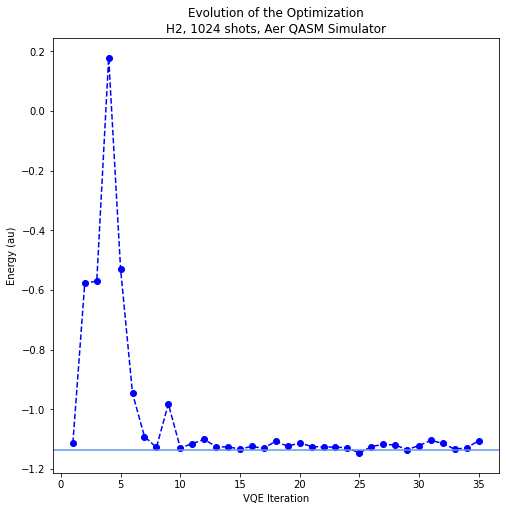

In [27]:
fig, ax1 = plt.subplots(figsize=[8,8])

nfev = evolution["nfev"][-1]

title = "Evolution of the Optimization\n{}, ".format(name)

if backendName != "Aer State Vector Simulator":
  title += "{} shots, ".format(shots)
title += "{}".format(backendName)

ax1.set_title(title)

color1 = 'b'
ax1.plot(range(1,nfev+1), energies, '--o', color = color1)
ax1.set_xlabel("VQE Iteration")
ax1.set_ylabel("Energy (au)")

plt.axhline(y = exactEnergy, color = 'cornflowerblue' , linestyle = '-')
color2 = 'r'